In [1]:
use_cuda_numpy = False
if use_cuda_numpy:
    import numpy as np
    import matplotlib.pyplot as plt
    import cupy as cnp
    import cupyx.scipy as csp
    import cupyx.scipy.sparse.linalg as clg
    from time import time
    import os
    
else:
    import numpy as cnp
    import numpy as np
    import matplotlib.pyplot as plt
    import scipy as csp
    import scipy.sparse.linalg as clg
    from time import time
    import os

# 3D Time Dependent Schrödinger Equation

### Routines

In [2]:
#Discretized Hamiltonian as a Sparse Matrix
def cuda_get_discrete_U_L(Nx, Ny, Nz, dx, dy, dz, dt, mx, my, mz, hbar):
    main_diagonal = 1+1j*dt*0.5*hbar*(1/dx**2/mx+1/dy**2/my+1/dz**2/mz)*cnp.ones(Nx*Ny*Nz, dtype=complex_dtype)
    for i in range(Nx):
        for j in range(Ny):
            for k in range(Nz):
                main_diagonal[k*Nx*Ny+j*Nx+i] += 1j*dt*V_ijk[i,j,k]/2/hbar
    x_diagonals = -1j*dt*hbar/(4*mx*dx**2)*cnp.ones(Nx*Ny*Nz-1, dtype=complex_dtype)
    y_diagonals = -1j*dt*hbar/(4*my*dy**2)*cnp.ones(Nx*Ny*Nz-Nx, dtype=complex_dtype)
    z_diagonals = -1j*dt*hbar/(4*mz*dz**2)*cnp.ones(Nx*Ny*Nz-Nx*Ny, dtype=complex_dtype)
    # There are some zeros we need to place in these diagonals
    for j in range(Ny*Nz-1):
        x_diagonals[(j+1)*Nx-1] = 0
    for k in range(Nz-1):
        y_diagonals[ (k+1)*Nx*Ny-Nx:(k+1)*Nx*Ny ] = 0
    
    return csp.sparse.diags( diagonals=
        (main_diagonal, x_diagonals, x_diagonals,y_diagonals, y_diagonals, z_diagonals, z_diagonals),
        offsets=cnp.array([0, 1, -1, Nx, -Nx, Nx*Ny, -Nx*Ny]), dtype=complex_dtype,format='csc')

### Simulation Parameters

In [3]:
# name for output directories
exp_name = "3D_test_2"

# Complex number precision
complex_dtype = cnp.csingle # 64 bit #cnp.cdouble # 128 bit
real_dtype = cnp.single # 32 bit # cnp.double # 64 bit

# hbar, masses
hbar = 1
ms = [1,1,1]

# Time increment
dt = 0.01

# Number of time iterations
numIts = 600

# Number of points to be used per dimension
Ns = [40]*3 # (Nx, Ny, Nz)
Nx,Ny,Nz = Ns
 
# Output every
outputEvery = 24

# Number of Bohmian Trajectories to Sample and Evolve
numTrajs = 1000

# Dimensionality of the particles in the 3D configuration space
numDofPartic = 3 # aka a single 3D particle
numDofUniv = 3


# Time grid
ts = np.array([dt*j for j in range(numIts)])

# Intervals for calculating the wave function
xlowers = [-8,-8,-7]
xuppers = [8,8,11]

# Increments to be used per dimension
dxs = [(xuppers[j]-xlowers[j])/(Ns[j]-1) for j in range(3)] # (dx, dy, dz)
dx,dy,dz = dxs

#Create coordinates at which the solution will be calculated
nodes = [cnp.linspace(xlowers[j], xuppers[j], Ns[j]) for j in range(3)] # (xs, ys, zs)
xs,ys,zs = nodes

print("> Grid Settings:")
print(f"  Using Nx={Ns[0]} Ny={Ns[1]} Nz={Ns[2]} grid points.")
print(f"  Using dx={dxs[0]:.4} dy={dxs[1]:.4} dz={dxs[2]:.4} increments (atomic units)\n")

> Grid Settings:
  Using Nx=40 Ny=40 Nz=40 grid points.
  Using dx=0.4103 dy=0.4103 dz=0.4615 increments (atomic units)



Save the Simulation Parameters

In [4]:
# Save the Simulation Parameters
os.makedirs(f"./OUTPUTS/TISE_3D/{exp_name}/", exist_ok=True)
with open(f"./OUTPUTS/TISE_3D/{exp_name}/Settings.txt", "w") as f:
    f.write(f"numIts {numIts}\ndt {dt}\noutputEvery {outputEvery}\nNs {Ns}\nxlowers {xlowers}\nxuppers {xuppers}\n")
    f.write(f"numDofUniv {numDofUniv}\nnumDofPartic {numDofPartic}\n")
    f.write(f"numTrajs {numTrajs}\nhbar {hbar}\nms {ms}\nreal_dtype {real_dtype}\ncomplex_dtype {complex_dtype}\n")
    try:
        f.write(f"K_coulomb {K_coulomb} \nqs {qs}\n")
    except:
        f.write(f"K_coulomb {1} \nqs {[1,1,1]}\n")        

### Scenario

In [5]:
def harmonic(grid):
    return np.sum(grid**2, -1)

def spherical_slits_3D(grid,Vmax=20, Rshell=2, wshell=0.2,
            k_super=6, th1=17*np.pi/180, th2=40*np.pi/180, wslit=8*np.pi/180):
    Rs = np.sqrt(np.sum(grid**2, -1))
    Rs = np.where(Rs==0, 1e-4, Rs)
    thetas = cnp.arccos(grid[:,:,:,2]/Rs)
    return cnp.where(thetas<cnp.pi/2, 
            Vmax*cnp.exp(-cnp.abs((Rs-Rshell)/wshell)**k_super)*\
                (1-cnp.exp(-cnp.abs((thetas-th1)/wslit)**k_super)-\
                    cnp.exp(-cnp.abs((thetas-th2)/wslit)**k_super)), 0)

def torous_3D(grid, R=2):
    return grid[:,:,:,2]**2+(cnp.sqrt(grid[:,:,:,0]**2+grid[:,:,:,1]**2)-R)**2

In [6]:
K_coulomb=1
qs = [-1,-1,-1]

# Initial Wavefunction
def psi0_gaussian(grid, mus, sigmas, ps, hbar):
    # grid is [Nx,Ny, 2]
    return np.prod(1/(sigmas*np.sqrt(2*np.pi))**0.5*cnp.exp(-(grid-mus)**2/(4*sigmas**2))*cnp.exp(1j*(ps*grid)/hbar), axis=-1, dtype=complex_dtype)

def psi0_2gaussians(x,y,z, mus1, mus2, sigmas1, sigmas2, ps1, ps2, hbar):
    return np.prod(1/(sigmas1*np.sqrt(2*np.pi))**0.5*cnp.exp(-(grid-mus1)**2/(4*sigmas1**2))*cnp.exp(1j*(ps1*grid)/hbar), 
                   axis=-1, dtype=complex_dtype)+\
            np.prod(1/(sigmas2*np.sqrt(2*np.pi))**0.5*cnp.exp(-(grid-mus2)**2/(4*sigmas2**2))*cnp.exp(1j*(ps2*grid)/hbar), 
                    axis=-1, dtype=complex_dtype)

mus = cnp.array([0,0,4.5])
sigmas = cnp.array([1,1,0.7])
ps = cnp.array([0,0,-2.5])

# parameters for gaussian
mus1 = cnp.array([0,3,3])
sigmas1 = cnp.array([1,1,1])
u = cnp.array([0,-3,-1.5])
ps1 = 2*u/cnp.linalg.norm(u)

mus2 = cnp.array([0,-3,-3])
sigmas2 = cnp.array([1,1,1])
ps2 = -2*u/np.linalg.norm(u)
# choose the potential and the wavefunction
chosenV=spherical_slits_3D

grid=cnp.moveaxis(cnp.array(np.meshgrid(*nodes)).swapaxes(1,2),0,-1) #[Nx,Ny,Nz,3]
V_ijk = chosenV(grid)

psi0 = lambda grid: psi0_gaussian(grid, mus=mus, sigmas=sigmas, ps=ps, hbar=hbar)
#psi0 = lambda grid: psi0_2gaussians(grid, mus1=mus1, sigmas1=sigmas1, 
#               ps1=ps1, hbar=hbar,  mus2=mus2, sigmas2=sigmas2, ps2=ps2 )

### Simulation
Prepare Arrays

In [7]:
psi = psi0(grid).flatten('F')

In [8]:
# initialize Bohmian trajectories
# first get the pdf
#psi0 = cnp.asnumpy(psi)
pdf0 = (psi.conj()*psi).real
pdf0 = pdf0/pdf0.sum() # normalize strictly

# sample randomly
initial_trajs_idx = cnp.random.choice( pdf0.shape[0], 
            replace=True, size=(numTrajs), p=pdf0 ) #[numTrajs] indices
# need to convert them to positions
k_s = initial_trajs_idx//(Nx*Ny)
rest = initial_trajs_idx%(Nx*Ny)
j_s = rest//Nx
i_s = rest%Nx

# avoiding edges - probability density is zero there
i_s[i_s==0] = 1
i_s[i_s==Ns[0]-1] = Ns[0]-2
j_s[j_s==0] = 1
j_s[j_s==Ns[1]-1] = Ns[1]-2
k_s[k_s==0] = 1
k_s[k_s==Ns[2]-1] = Ns[2]-2

trajs = cnp.zeros((numTrajs, 6), dtype=real_dtype) #[numTrajs, 6=3posit+3momtum]
for tr, (i, j, k) in enumerate(zip(i_s,j_s,k_s)):
    trajs[tr, 0] = nodes[0][i]
    trajs[tr, 1] = nodes[1][j]
    trajs[tr, 2] = nodes[2][k]
    
cdxs = cnp.array(dxs)[cnp.newaxis,:]
cNs = cnp.array(Ns)[cnp.newaxis, :]
cxlowers = cnp.array(xlowers)[cnp.newaxis, :]
cxuppers = cnp.array(xuppers)[cnp.newaxis, :]
cms = cnp.array(ms)[cnp.newaxis, :]

Plot the potential energy profile and initial trajs

In [9]:
#%matplotlib inline

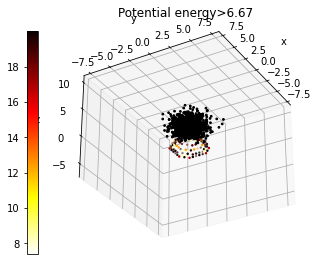

In [10]:
if use_cuda_numpy:
    V_ijk=cnp.asnumpy(V_ijk)
    trajs_numpy = cnp.asnumpy(trajs)
    grid = cnp.asnumpy(grid)
else:
    trajs_numpy = trajs
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
maxim = V_ijk.max()
minim = V_ijk.min()
zati=3
level_surface = grid[ V_ijk>maxim/zati, :]
colormap = ax.scatter3D(level_surface[:,0], level_surface[:,1], level_surface[:,2],
                    c=V_ijk[V_ijk>maxim/zati],
        cmap='hot_r', s=2, alpha=V_ijk[V_ijk>maxim/zati]/maxim ) #, antialiased=True)
ax.set_xlim((xlowers[0], xuppers[1]))
ax.set_ylim((xlowers[1], xuppers[1]))
ax.set_zlim((xlowers[2], xuppers[2]))

fig.colorbar(colormap, fraction=0.04, location='left')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title(f"Potential energy>{maxim/3:.3}")
ax.view_init(elev=-30, azim=30)
ax.scatter(trajs_numpy[:,0], trajs_numpy[:,1], trajs_numpy[:,2], c="black", s=3,
            alpha=1)
os.makedirs(f"./OUTPUTS/TISE_3D/{exp_name}/figs/", exist_ok=True)
image=f"./OUTPUTS/TISE_3D/{exp_name}/figs/energy_potential.png"
plt.savefig(image, dpi=150)
plt.show()

In [11]:
U_L = cuda_get_discrete_U_L(*Ns, *dxs, dt, *ms, hbar)
U_R = U_L.conj()
UL_LUdec = clg.splu( U_L )

Create Directories

In [12]:
os.makedirs(f"./OUTPUTS/TISE_3D/{exp_name}/pdf/", exist_ok=True)
os.makedirs(f"./OUTPUTS/TISE_3D/{exp_name}/trajs/", exist_ok=True)
os.makedirs(f"./OUTPUTS/TISE_3D/{exp_name}/moms/", exist_ok=True)

Run Iterations

In [14]:
dpsi_dx = cnp.zeros(Ns, dtype=complex_dtype)
dpsi_dy = cnp.zeros(Ns, dtype=complex_dtype)
dpsi_dz = cnp.zeros(Ns, dtype=complex_dtype)
p = cnp.zeros(dpsi_dx.shape+(3, ), dtype=real_dtype) #[3, Nx, Ny, Nz]

for it, t in enumerate(ts):
    psi_tensor = psi.reshape(Ns[::-1]).swapaxes(0,-1) #[Nx,Ny,Nz]
    
    # BOHMIAN MOMENTUM FIELD #####################################
    # first the gradient of the wavefunction at each point
    # X
    # boundaries with simple Euler formula O(dx)
    dpsi_dx[0, :, :] = (psi_tensor[1, :, :]-psi_tensor[0, :, :])/dx
    dpsi_dx[-1, :, :] = (psi_tensor[-1, :, :]-psi_tensor[-2, :, :])/dx
    # next boundaries with centered difference O(dx**2)
    dpsi_dx[1,:,:] = (psi_tensor[2,:,:]-psi_tensor[0,:,:])/(2*dx)
    dpsi_dx[-2,:,:] = (psi_tensor[-1,:,:]-psi_tensor[-3,:,:])/(2*dx)
    # rest with O(dx**4) centered difference
    dpsi_dx[2:-2,:,:] = (-psi_tensor[4:,:,:]+8*psi_tensor[3:-1,:,:]-8*psi_tensor[1:-3,:,:]+psi_tensor[:-4,:,:])/(12*dx)

    # DY
    # boundaries with simple Euler formula O(dx)
    dpsi_dy[:, 0, :] = (psi_tensor[:,1, :]-psi_tensor[:,0, :])/dy
    dpsi_dy[:,-1, :] = (psi_tensor[:,-1, :]-psi_tensor[:,-2, :])/dy
    # next boundaries with centered difference O(dx**2)
    dpsi_dy[:,1,:] = (psi_tensor[:,2,:]-psi_tensor[:,0,:])/(2*dy)
    dpsi_dy[:,-2,:] = (psi_tensor[:,-1,:]-psi_tensor[:,-3,:])/(2*dy)
    # rest with O(dx**4) centered difference
    dpsi_dy[:,2:-2,:] = (-psi_tensor[:,4:,:]+8*psi_tensor[:,3:-1,:]-8*psi_tensor[:,1:-3,:]+psi_tensor[:,:-4,:])/(12*dy)

    # DZ
    # boundaries with simple Euler formula O(dx)
    dpsi_dz[:,:,0] = (psi_tensor[:,:,1]-psi_tensor[:,:,0])/dz
    dpsi_dz[:,:,-1] = (psi_tensor[:,:,-1]-psi_tensor[:,:,-2])/dz
    # next boundaries with centered difference O(dx**2)
    dpsi_dz[:,:,1] = (psi_tensor[:,:,2]-psi_tensor[:,:,0])/(2*dz)
    dpsi_dz[:,:,-2] = (psi_tensor[:,:,-1]-psi_tensor[:,:,-3])/(2*dz)
    # rest with O(dx**4) centered difference
    dpsi_dz[:,:,2:-2] = (-psi_tensor[:,:,4:]+8*psi_tensor[:,:,3:-1]-8*psi_tensor[:,:,1:-3]+psi_tensor[:,:,:-4])/(12*dz)

    # px, py, pz
    p[:,:,:,0] = hbar*(dpsi_dx/psi_tensor).imag
    p[:,:,:,1] = hbar*(dpsi_dy/psi_tensor).imag
    p[:,:,:,2] = hbar*(dpsi_dz/psi_tensor).imag      

    # TRAJ MOMENTA ##################################################
    # if no trajectory surpasses below the node 0 or J-1 at any time, 
    # traj will always be among (0,J-1) and traj//dxs will be among [0,J-1]
    trajs_idxs = (((trajs[:,:3]-cxlowers)//cdxs).T).astype(cnp.uint) # [3, numTrajs] the closest index from below along each axis
    # relative distance to the closest index from below point along each dimension
    # the closer, the bigger its weight should be for the trajectory propagation
    ratx_down = ((trajs[:,0]-xs[ trajs_idxs[0] ])/(xs[ trajs_idxs[0]+1 ]-xs[ trajs_idxs[0] ]))[:,np.newaxis]
    raty_down = ((trajs[:,1]-ys[ trajs_idxs[1] ])/(ys[ trajs_idxs[1]+1 ]-ys[ trajs_idxs[1] ]))[:,np.newaxis]
    ratz_down = ((trajs[:,2]-zs[ trajs_idxs[2] ])/(zs[ trajs_idxs[2]+1 ]-zs[ trajs_idxs[2] ]))[:,np.newaxis]
    # Get the interpolated momenta
    trajs[:, 3:] = ratx_down*raty_down*ratz_down* p[ trajs_idxs[0]+1, trajs_idxs[1]+1, trajs_idxs[2]+1 ] +\
        (1-ratx_down)*raty_down*ratz_down* p[ trajs_idxs[0], trajs_idxs[1]+1, trajs_idxs[2]+1 ] +\
        ratx_down*(1-raty_down)*ratz_down* p[ trajs_idxs[0]+1, trajs_idxs[1], trajs_idxs[2]+1 ] +\
        ratx_down*raty_down*(1-ratz_down)* p[ trajs_idxs[0]+1, trajs_idxs[1]+1, trajs_idxs[2] ] +\
        (1-ratx_down)*(1-raty_down)*ratz_down* p[ trajs_idxs[0], trajs_idxs[1], trajs_idxs[2]+1 ] +\
        ratx_down*(1-raty_down)*(1-ratz_down)* p[ trajs_idxs[0]+1, trajs_idxs[1], trajs_idxs[2] ] +\
        (1-ratx_down)*raty_down*(1-ratz_down)* p[ trajs_idxs[0], trajs_idxs[1]+1, trajs_idxs[2] ] +\
        (1-ratx_down)*(1-raty_down)*(1-ratz_down)* p[ trajs_idxs[0], trajs_idxs[1], trajs_idxs[2] ]
    
    # OUTPUT #####################################################
    if it%outputEvery == 0:
        print(f"\n > It {it}/{numIts}")
        # compute the magnitude squared of the wavefunction
        pdf = (psi_tensor.conj()*psi_tensor).real
        # Approximate the norm
        print(f"   Iteration {it} Approx.Norm = {pdf.sum()*dx*dy*dz:.4}")
        if use_cuda_numpy:
            pdf = cnp.asnumpy(pdf)
            trajs_numpy = cnp.asnumpy(trajs)
            p_numpy = cnp.asnumpy(p)
        else:
            trajs_numpy = trajs
            p_numpy = p
        
        np.save(f"./OUTPUTS/TISE_3D/{exp_name}/pdf/pdf_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy",
                pdf, allow_pickle=True) #[Nx,Ny,Nz]
        np.save(f"./OUTPUTS/TISE_3D/{exp_name}/trajs/trajs_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy",
                trajs_numpy, allow_pickle=True) #[numTrajs, 6]
        np.save(f"./OUTPUTS/TISE_3D/{exp_name}/moms/momentum_field_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy",
                p_numpy, allow_pickle=True) #[Nx,Ny,Nz, 6]
        
        
    # Evolve trajectories using the interpolated velocity field
    trajs[:, :3] = trajs[:,:3] + dt*trajs[:,3:]/cms #[numTrajs, 3]
    
    # Those trajectories that get out of bounds should bounce back by the amount they got out
    while(cnp.any(trajs[:,:numDofUniv]>=cxuppers) or cnp.any(trajs[:,:numDofUniv]<=cxlowers)):
        trajs[:,:3] = cnp.where( trajs[:,:3]>cxuppers, cxuppers-(trajs[:,:3]-cxuppers) ,trajs[:,:3] )
        trajs[:,:3] = cnp.where( trajs[:,:3]<cxlowers, cxlowers+(cxlowers-trajs[:,:3]) ,trajs[:,:3] )   
    
    # NEXT PSI ####################################################
    # compute the next time iteration's wavefunction
    U_Rpsi_prev = U_R@psi # this is the vector b in Ax=b
    psi = UL_LUdec.solve(U_Rpsi_prev)

/tmp/ipykernel_39154/1306615159.py:42: RuntimeWarning: overflow encountered in true_divide
  p[:,:,:,0] = hbar*(dpsi_dx/psi_tensor).imag
/tmp/ipykernel_39154/1306615159.py:42: RuntimeWarning: invalid value encountered in true_divide
  p[:,:,:,0] = hbar*(dpsi_dx/psi_tensor).imag
/tmp/ipykernel_39154/1306615159.py:43: RuntimeWarning: overflow encountered in true_divide
  p[:,:,:,1] = hbar*(dpsi_dy/psi_tensor).imag
/tmp/ipykernel_39154/1306615159.py:43: RuntimeWarning: invalid value encountered in true_divide
  p[:,:,:,1] = hbar*(dpsi_dy/psi_tensor).imag
/tmp/ipykernel_39154/1306615159.py:44: RuntimeWarning: overflow encountered in true_divide
  p[:,:,:,2] = hbar*(dpsi_dz/psi_tensor).imag



 > It 0/600
   Iteration 0 Approx.Norm = 1.0

 > It 24/600
   Iteration 24 Approx.Norm = 1.0

 > It 48/600
   Iteration 48 Approx.Norm = 1.0

 > It 72/600
   Iteration 72 Approx.Norm = 1.0

 > It 96/600
   Iteration 96 Approx.Norm = 1.0

 > It 120/600
   Iteration 120 Approx.Norm = 1.0

 > It 144/600
   Iteration 144 Approx.Norm = 1.0

 > It 168/600
   Iteration 168 Approx.Norm = 1.0

 > It 192/600
   Iteration 192 Approx.Norm = 1.0

 > It 216/600
   Iteration 216 Approx.Norm = 1.0

 > It 240/600
   Iteration 240 Approx.Norm = 1.0

 > It 264/600
   Iteration 264 Approx.Norm = 1.0

 > It 288/600
   Iteration 288 Approx.Norm = 1.0

 > It 312/600
   Iteration 312 Approx.Norm = 1.0

 > It 336/600
   Iteration 336 Approx.Norm = 1.0


KeyboardInterrupt: 

Free stuff

In [15]:
if use_cuda_numpy:
    cnp.get_default_memory_pool().free_all_blocks()
    cnp.get_default_pinned_memory_pool().free_all_blocks()

### Animation Generation

In [16]:
if use_cuda_numpy:
    nodes = [cnp.asnumpy(nodel) for nodel in nodes]
    xs,ys,zs = nodes

Generate png

In [17]:
os.makedirs(f"./OUTPUTS/TISE_3D/{exp_name}/figs/", exist_ok=True)
image_paths = []
dpi = 100

every=1 # Only take one data point every this number in each axis to plot
grid=np.array(np.meshgrid(*nodes)).swapaxes(1,2)[:,::every, ::every, ::every] #[3,Nx,Ny,Nz]
print(f"Using a mesh in the plot of {grid.shape}")
fig = plt.figure( figsize=(21,7))

plt.style.use('dark_background')

for it, t in enumerate(ts):
    if it%outputEvery==0:
        print(f"\n > It {it}/{numIts}")
        fig.clf()
        pdf = np.load(f"./OUTPUTS/TISE_3D/{exp_name}/pdf/pdf_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")
        trajs = np.load(f"./OUTPUTS/TISE_3D/{exp_name}/trajs/trajs_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")
        
        ax = fig.add_subplot(131, projection='3d')
        # PDF TRANSP ############################################################
        maxim = pdf.max()
        minim = pdf.min()
        level_surface = grid[:, pdf>maxim/3]
        colormap = ax.scatter(*level_surface, c=pdf[pdf>maxim/3],
                cmap='hot_r', s=2, alpha=pdf[pdf>maxim/3]/maxim ) #, antialiased=True)
        ax.set_xlim((xlowers[0], xuppers[1]))
        ax.set_ylim((xlowers[1], xuppers[1]))
        ax.set_zlim((xlowers[2], xuppers[2]))
        ax.view_init(elev=-30, azim=30)

        fig.colorbar(colormap, fraction=0.04, location='left')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.set_title(f"Probability Density>{maxim/3:.3}\n it={it} t={t:.4}")
        
        # PDF SURFACE LEVELS #####################################################
        ax = fig.add_subplot(132, projection='3d')
        level_surface = grid[:,pdf>maxim/3]
        ax.set_zlim(xlowers[-1], xuppers[-1])
        for k,z in enumerate(zs):
            cset = ax.contour(grid[0,:,:,0], grid[1,:,:,0], pdf[:,:,k], 
                        7, zdir='z', offset=z, cmap='hot_r', vmin=minim, vmax=maxim,
                             alpha=pdf[:,:,k].max()/maxim)
        ax.set_title(f"Probability Density\n it={it} t={t:.4}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        fig.colorbar(colormap, fraction=0.04, location='bottom', ax=ax)
        ax.view_init(elev=-30, azim=30)

        # PDF + TRAJECTORIES ##############################################
        ax = fig.add_subplot(133, projection='3d')
        #colormap = ax.scatter3D(*grid, c=pdf[ ::every, ::every, ::every],
        #               cmap='hot_r', s=0.1, alpha=0.4 ) #, antialiased=True)
        cset = ax.contour(grid[0,:,:,0], grid[1,:,:,0], pdf.sum(axis=2), 7, zdir='z', offset=xlowers[2], cmap='hot_r')
        cset = ax.contour(grid[0,:,0,:], pdf.sum(axis=1), grid[2,:,0,:], 7, zdir='y', offset=xuppers[1], cmap='hot_r')
        cset = ax.contour(pdf.sum(axis=0), grid[1,0,:,:], grid[2,0,:,:], 7, zdir='x', offset=xlowers[0], cmap='hot_r')
        #fig.colorbar(cset, fraction=0.04, location='left')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.set_title(f"Trajectories and Projected Probability Density Contours\n it={it} t={t:.4}")
        ax.scatter(trajs[:,0], trajs[:,1], trajs[:,2], c="white", s=3,
                    alpha=1)
        ax.view_init(elev=-30, azim=30)

        image=f"./OUTPUTS/TISE_3D/{exp_name}/figs/it_{it}.png"
        plt.savefig(image, dpi=dpi)
        image_paths.append(image)
        


Using a mesh in the plot of (3, 40, 40, 40)

 > It 0/600

 > It 24/600

 > It 48/600

 > It 72/600

 > It 96/600

 > It 120/600

 > It 144/600

 > It 168/600

 > It 192/600

 > It 216/600

 > It 240/600

 > It 264/600

 > It 288/600

 > It 312/600

 > It 336/600

 > It 360/600

 > It 384/600

 > It 408/600


FileNotFoundError: [Errno 2] No such file or directory: './OUTPUTS/TISE_3D/3D_test_2/pdf/pdf_it_408_numIts_600_dt_0.01.npy'

<Figure size 1512x504 with 0 Axes>

Generate gif

In [ ]:
import imageio
fps=7
images_for_animation = [ imageio.v2.imread(image_path) for image_path in image_paths]
imageio.mimsave(f'./OUTPUTS/TISE_3D/{exp_name}/CN_TISE_{exp_name}.gif', images_for_animation, duration=fps**-1*len(images_for_animation))

Erase png

In [ ]:
#for image_path in image_paths:
#    os.remove(image_path)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
r = np.linspace(1e-5, 3, 200)
a1 = 1/r 
a2 = 1/r**2
a3 = 1/r**3
plt.plot(r, a1, label="1/r")
plt.plot(r, a2, label="1/r**2")
plt.plot(r, a3, label="1/r**3")
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
a=np.array([[['j0k0i0', 'j0k1i0', 'j0k2i0'], ['j1k0i0', 'j1k1i0', 'j1k2i0'],['j2j0i0', 'j2k1i0', 'j2k2i0']], [['j0k0i1', 'j0k1i1', 'j0k2i1'], ['j1k0i1', 'j1k1i1', 'j1k2i1'],['j2k0i1', 'j2k1i1', 'j2k2i1']]])
a.flatten('F')